## Section 3
Comparing time series forecasting models.
In this section, we will deal with 2 time series forecasting algorithms, presenting each model with its efficiency on the data set, examining how it copes with predicting response time in the data sets, and finally comparing their performances.

### **SARIMA**
An extension of ARIMA that adds a seasonal component (P,D,Q) with a fixed periodicity (e.g. 24 hours).
For our task: It allows us to capture recurring changes (peak hours) in hours or days that affect the response time.

The benefit is: It combines trend, noise and seasonality together and gives more accurate forecasts when there is a clear seasonal pattern.


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


In [2]:
df = pd.read_csv('Tavily Data Analysis Home Test - Time Series.csv')
df.head()

,DATE_TIME,VOLUME,RESP_AVG
0,2025-03-22 8:00:00,442,7.085964
1,2025-03-22 9:00:00,418,8.405124
2,2025-03-22 11:00:00,507,7.779719
3,2025-03-22 12:00:00,559,6.877425
4,2025-03-22 13:00:00,602,8.178685


In [3]:
df = df.set_index('DATE_TIME')
df.index = pd.to_datetime(df.index)
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1706 entries, 2025-03-22 08:00:00 to 2025-06-15 07:00:00
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   VOLUME    1706 non-null   int64  
 1   RESP_AVG  1706 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 40.0 KB
None
             VOLUME     RESP_AVG
count   1706.000000  1706.000000
mean    2640.644197     7.848615
std     2410.114417     2.171984
min      362.000000     4.594024
25%     1136.000000     6.904281
50%     2052.500000     7.694853
75%     3297.000000     8.506829
max    23259.000000    64.354239


In [4]:
df.head()

,VOLUME,RESP_AVG
DATE_TIME,,
2025-03-22 08:00:00,442,7.085964
2025-03-22 09:00:00,418,8.405124
2025-03-22 11:00:00,507,7.779719
2025-03-22 12:00:00,559,6.877425
2025-03-22 13:00:00,602,8.178685


## features enginerring

In [6]:
df['log_VOLUME'] = np.log1p(df['VOLUME'])
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday

In [7]:
df = df.dropna()
df.head()

,VOLUME,RESP_AVG,log_VOLUME,hour,weekday
DATE_TIME,,,,,
2025-03-22 08:00:00,442,7.085964,6.093570,8,5
2025-03-22 09:00:00,418,8.405124,6.037871,9,5
2025-03-22 11:00:00,507,7.779719,6.230481,11,5
2025-03-22 12:00:00,559,6.877425,6.327937,12,5
2025-03-22 13:00:00,602,8.178685,6.401917,13,5


## Train/Test Data.

In [8]:
#split data into train and test
split = int(len(df) * 0.8)
train = df[:split]
test = df[split:]

In [9]:
#for training
y_train = train['RESP_AVG']
exog_train = train[['log_VOLUME', 'hour', 'weekday']]

#for testing
exog_test = test[['log_VOLUME', 'hour', 'weekday']]
y_test = test['RESP_AVG']

In [11]:
#train model 
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(y_train, exog=exog_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
model_fit = model.fit(disp=False)

/Users/jonatanbuga/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jonatanbuga/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [13]:
#predict model 
forecast = model_fit.get_forecast(steps=len(test), exog=exog_test)
y_pred = forecast.predicted_mean

/Users/jonatanbuga/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/jonatanbuga/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [15]:
# 3 index error metrics 
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'Mean Absolute Error: {mae:.3f} seconds')
print(f'Root Mean Squared Error: {rmse:.3f} seconds')
print(f'Mean Absolute Percentage Error: {mape:.3%}')

Mean Absolute Error: 1.105 seconds
Root Mean Squared Error: 1.378 seconds
Mean Absolute Percentage Error: 16.803%


## Summary of error dimensions:
### mae -
Measures the average of the absolute values ​​of the errors. That is, on average, by how many seconds the prediction deviated from reality, without regard to a third positive area.

**Why is it relevant?**
The index directly displays the error in seconds, it is really easy to understand that it means that the error was .... seconds for example.
In addition, since the index is an average of absolute values, each observation yields the same weight in the error without taking extreme peaks out of proportion

### rmse -
It is essentially the root mean square of the errors, that is, the size of the average error but squared - so that large errors are amplified more.

**Why is it relevant?**
Very sensitive to peaks, instead of needing to punish large errors, the index will express them more strongly.

### mape -
The average of the errors in percentages relative to the true error.
That is, what percentage of the average, each error represents.

**Why is it relevant?**
A relative index allows for performance comparisons between different models or time series, for example, even if resp_avg has different value ranges.
This index is sensitive to values ​​close to 0, but in our data resp_avg will never reach 0 seconds.

## plots for Actual vs Predict  

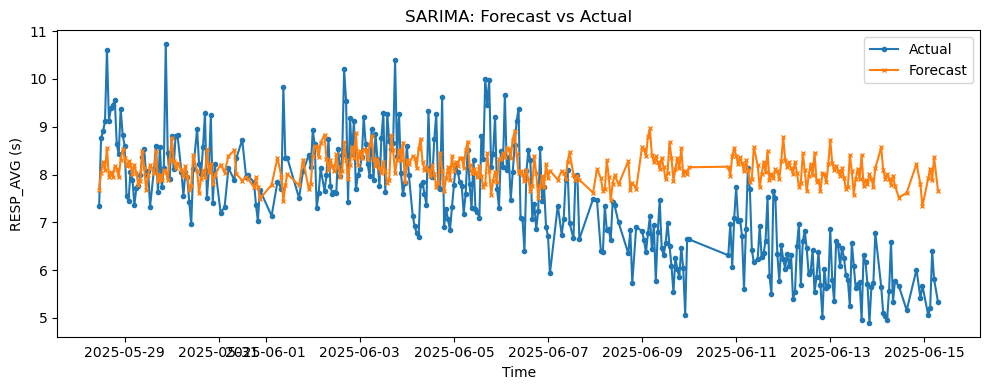

In [16]:
#Actual vs Predicted Plot
plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test,  label='Actual', marker='o', markersize=3)
plt.plot(y_test.index, y_pred,  label='Forecast', marker='x', markersize=3)
plt.title('SARIMA: Forecast vs Actual')
plt.xlabel('Time')
plt.ylabel('RESP_AVG (s)')
plt.legend()
plt.tight_layout()
plt.show()

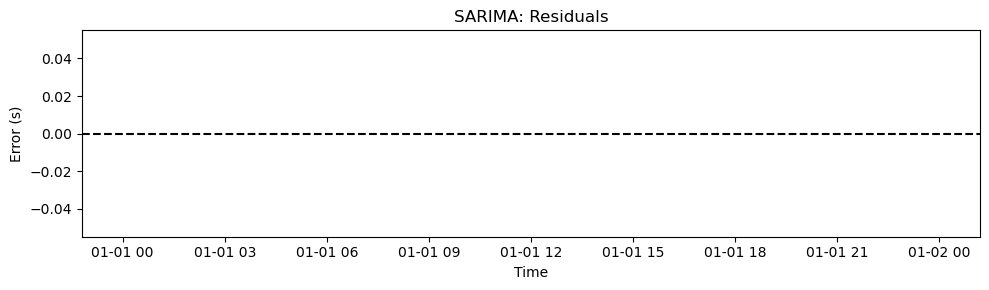

In [17]:
#residuals = y_test - y_pred
residuals = y_test - y_pred
plt.figure(figsize=(10,3))
plt.plot(residuals.index, residuals, label='Residuals')
plt.axhline(0, color='black', linestyle='--')
plt.title('SARIMA: Residuals')
plt.xlabel('Time')
plt.ylabel('Error (s)')
plt.tight_layout()
plt.show()

## Xgboost Model 
The model builds a series of regression decision trees (usually shallow), so that each tree tries to correct the errors of the previous trees.
At each iteration, a new tree is added to the model to minimize a cost function (e.g. MSE) using the gradient of the error. The process gradually strives for a more accurate prediction, as the trees “introduce” small but cumulative corrections.

Why is it relevant to our task?
1. By creating features such as log_VOLUME, hour, weekday, rm_resp and rs_resp. XGBoost knows how to automatically choose which of them are the most significant and build interactions between them.

2. Nonlinear relationship: The relationship between load and response time may not be linear, and XGBoost will catch jumps and sharp changes that were not present in a simple regression.

In [ ]:
#adding anther feature to the model
df['lag1_RESP_AVG'] = df['RESP_AVG'].shift(1)
df['lag2_RESP_AVG'] = df['RESP_AVG'].shift(2)

df['rm_resp_3h'] = df['RESP_AVG'].rolling(window=3).mean().shift(1)
df['rs_resp_3h'] = df['RESP_AVG'].rolling(window=3).std().shift(1)



In [33]:
df_xgb = df.dropna(subset=['RESP_AVG', 'log_VOLUME', 'lag1_RESP_AVG', 'lag2_RESP_AVG', 'rm_resp_3h', 'rs_resp_3h','hour', 'weekday']).copy()
df_xgb

,VOLUME,RESP_AVG,log_VOLUME,hour,weekday,lag1_RESP_AVG,lag2_RESP_AVG,rm_resp_3h,rs_resp_3h
DATE_TIME,,,,,,,,,
2025-03-22 12:00:00,559,6.877425,6.327937,12,5,7.779719,8.405124,7.756935,0.659875
2025-03-22 13:00:00,602,8.178685,6.401917,13,5,6.877425,7.779719,7.687422,0.768020
2025-03-22 14:00:00,617,7.887081,6.426488,14,5,8.178685,6.877425,7.611943,0.666656
2025-03-22 15:00:00,758,7.490153,6.632002,15,5,7.887081,8.178685,7.647730,0.682851
2025-03-22 16:00:00,706,7.232271,6.561031,16,5,7.490153,7.887081,7.851973,0.345606
...,...,...,...,...,...,...,...,...,...
2025-06-15 02:00:00,2990,5.056264,8.003363,2,6,5.676927,5.416682,5.701708,0.298190
2025-06-15 03:00:00,2872,5.218309,7.963112,3,6,5.056264,5.676927,5.383291,0.311676
2025-06-15 04:00:00,2650,6.393903,7.882692,4,6,5.218309,5.056264,5.317167,0.321925


**The significance of choosing to add more features to a dataset:**

1. lag1_RESP_AVG - the immediate dependence between the response time by time period, and the time just before. Since there are many cases where time series exhibit strong autocorrelation, this feature allows the model to learn this pattern.
2. lag2_RESP_AVG - a long-term dependence to a lesser extent than lag1, more than one hour. It allows the model to identify short-term trends that last more than one hour.
3. rm_resp_3h - a moving average of the previous three hours, it captures a slight trend in the short-to-medium term: if the response time gradually increases, the rm will increase accordingly.
4. rs_resp_3h - a standard deviation of the previous three hours, it captures volatility. How much the values vary around the moving average.

## create model and split data

In [34]:
#feature 
features = ['log_VOLUME', 'lag1_RESP_AVG', 'lag2_RESP_AVG', 'rm_resp_3h', 'rs_resp_3h', 'hour', 'weekday']

X = df_xgb[features]
y = df_xgb['RESP_AVG']

In [35]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


In [36]:
#create xgboost model
xgb_model = xgb.XGBRegressor(n_estimators=100,subsample =0.8, learning_rate=0.1, max_depth=4, random_state=42)

#train the model
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

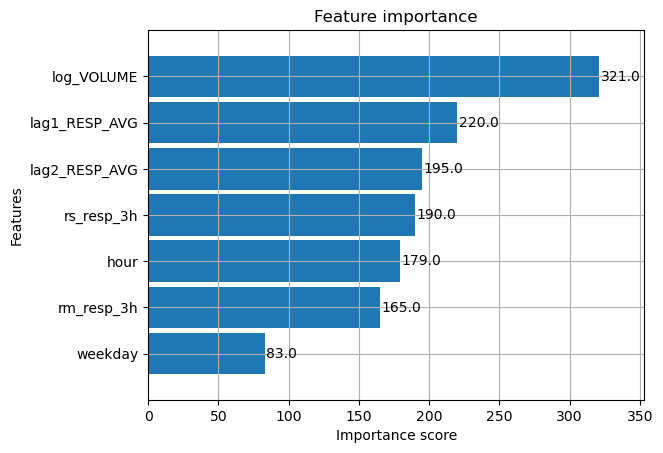

In [37]:
#feature importance
from xgboost import plot_importance
_ = plot_importance(xgb_model,height=0.9)

## forecast on Test set 

In [ ]:
#predict on Test set
X_test['y_pred_xgb'] = xgb_model.predict(X_test)
xgb_all = pd.concat([X_test, y_test], axis=1)

In [39]:
# 3 index error metrics
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)

print('XGBoost Model Performance:')
print(f'Mean Absolute Error: {mae_xgb:.3f} seconds')
print(f'Root Mean Squared Error: {rmse_xgb:.3f} seconds')
print(f'Mean Absolute Percentage Error: {mape_xgb:.3%}')

XGBoost Model Performance:
Mean Absolute Error: 0.763 seconds
Root Mean Squared Error: 0.952 seconds
Mean Absolute Percentage Error: 11.060%


## plots for Actual vs Predict 

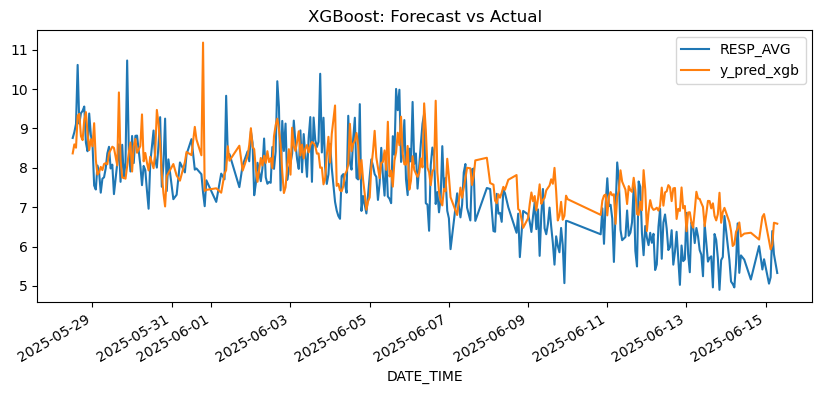

In [42]:
_ = xgb_all[['RESP_AVG', 'y_pred_xgb']].plot(figsize=(10, 4), title='XGBoost: Forecast vs Actual')

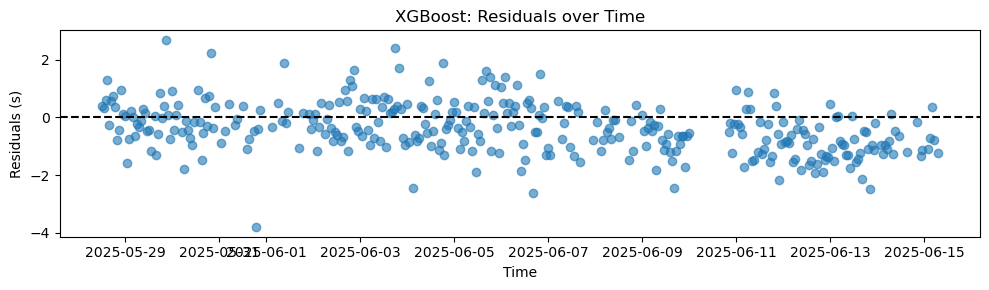

In [43]:
#Residuals
residuals_xgb = y_test - y_pred_xgb
plt.figure(figsize=(10,3))
plt.scatter(y_test.index, residuals_xgb, alpha=0.6)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Residuals (s)')
plt.title('XGBoost: Residuals over Time')
plt.tight_layout()
plt.show()

### **Analysis of the graphs on the xgboost model:**
**actual vs predict-**
1. Better fit to peaks. The orange curve (model predictions) follows sharp changes in actual more closely.
2. Wider coverage of the data. Even when the average response time drops below 6 seconds at the end of the period, the xgboost model almost accurately predicts the downward trend.
3. Dealing with extreme points - the peaks where the actual rises to its extreme point almost match the points that the model manages to reach, which indicates an ability to handle anomalies well.

**Residuals-**
1. There is no fixed seasonal/trend pattern. It does not appear that with an increase or decrease in time, the errors increase or decrease. This indicates the stability of the model.

# Final conclusions and comparison between the models:

**The xgboost model performs better.**
- In all three error metrics we tested - MAE, RMSE, MAPE, the xgboost model leads with a sharp and statistical improvement. In addition, the graphs we tested indicate a better fit to trends and outliers, and there are almost no persistent errors that do not match reality.

**Explanation of why it won -**

The xgboost model's ability to capture nonlinear patterns, and complex interactions between features allows it to adapt better to short-term changes and anomalies. Compared to sarima, which requires calibration of the parameters in a seasonal/trendy manner and is a linear model in essence.

**Do different metrics lead to different conclusions?**

All metrics clearly and consistently support that xgboost is a more accurate and better model for the task. I did not identify a situation where there was a metric that supported sarima more than xgboost.